<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Описание проекта: компания "Чётенькое такси" стремится соответствовать названию, для того, чтобы клиенты были довольны, необходимо правильно предсказывать нагрузку у аэропортов, ведь иногда водителей может понадобиться больше, чем существует заказов на данный момент.
    
Цель исследования: построить модель для предсказания количества заказов на следующий час 
    
Ход исследования:

    Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов
    
    Предобработка данных: обработка пропущенных значений, удаление дубликатов и т.д.
    
    Исследовательский анализ данных: изучение количества заказов, тренда и сезонности на графике
    
    Выбор лучшей модели: обучение моделей и выбор лучшей из них по метрике RMSE
    
    Общий вывод: резюмирование полученных результатов, формулировка ключевых выводов.

## Подготовка

In [1]:
import sys
!pip install eli5 -q
!pip install -U scikit-learn -q
!"{sys.executable}" -m pip install phik -q

In [2]:
RANDOM_STATE=42
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
    TimeSeriesSplit
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import(
    mean_squared_error
)
import statsmodels.api as sm

Выполню загрузку данных

In [3]:
taxi=pd.read_csv('/datasets/taxi.csv')
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Проверю данные на пропуски

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Теперь изучу данные на наличие дубликатов

In [5]:
sum(taxi.duplicated())

0

Ресемплирую данные по 1 часу и построю график

In [6]:
taxi['datetime']=taxi['datetime'].astype('datetime64')
taxi=taxi.set_index('datetime')
taxi.sort_index(inplace=True)

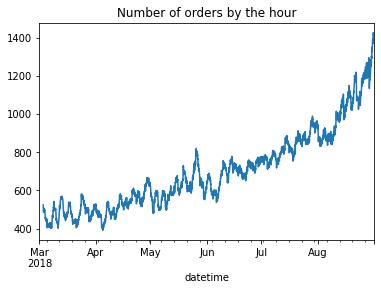

In [7]:
res=taxi.resample('1H').mean()
res['sum'] = res['num_orders'].rolling(50).sum()
res['sum'].plot()
plt.title('Number of orders by the hour')
plt.show()

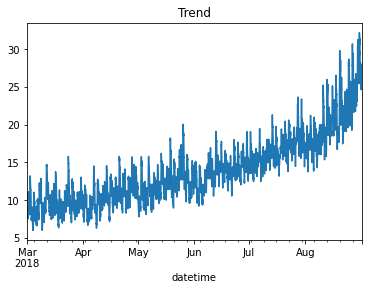

In [8]:
decomposition = sm.tsa.seasonal_decompose(taxi,period=100)
decomposition.trend.plot()
plt.title('Trend')
plt.show()

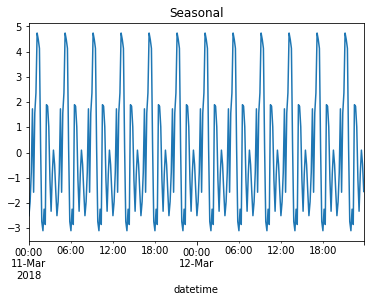

In [9]:
decomposition2 = sm.tsa.seasonal_decompose(taxi['2018-03-11':'2018-03-12'],period=24)
decomposition2.seasonal.plot()
plt.title('Seasonal')
plt.show()

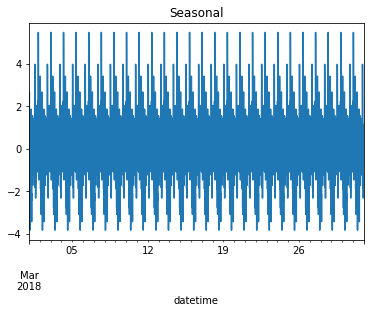

In [10]:
decomposition2 = sm.tsa.seasonal_decompose(taxi['2018-03-01':'2018-03-31'],period=168)
decomposition2.seasonal.plot()
plt.title('Seasonal')
plt.show()

Как можно увидеть на графиках, линия тренда показывает, что количество заказов увеличивается к осени, а сезонности не наблюдается

Визуализирую конкретный день(11 марта) и конкретный месяц(март 2018 года)

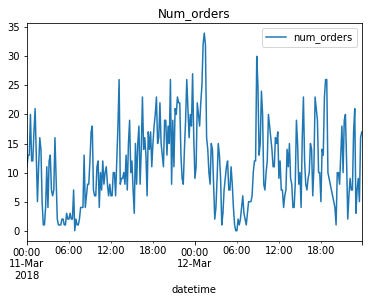

In [11]:
day=taxi['2018-03-11':'2018-03-12']
day.plot()
plt.title('Num_orders')
plt.show()

Можно заметить, что самое популярное время наступает ближе к вечеру, однако уже после 00:00 заказов становится гораздо меньше, наблюдается тренд

## Анализ

Пропусков в данных не обнаружено, среднее количество заказов колеблется от 10 до 20, однако ближе к осени среднее количество заказов растет- наблюдается тренд, также гораздо больше заказов вечером.

## Обучение

Напишу функцию для создания признаков.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
taxi=taxi.resample('1H').sum()

In [14]:
make_features(taxi,5,50)
taxi=taxi.dropna()
y=taxi['num_orders']
X=taxi.drop('num_orders',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False,test_size=0.1)

In [15]:
num_cols=['lag_1', 'lag_2','lag_3','lag_4', 'lag_5','rolling_mean']
ohe_cols=['hour','day','dayofweek']
ohe_pipe = Pipeline([
        ('ohe',OneHotEncoder(drop='first',handle_unknown='error'))])
preprocessing=ColumnTransformer([
    ('ohe',ohe_pipe,ohe_cols),
    ('num',StandardScaler(),num_cols)
],remainder='passthrough')
pipe_final=Pipeline([
    ('preprocessor',preprocessing),
    ('models',DecisionTreeRegressor())
])
param_distributions=[
{
    'models':[DecisionTreeRegressor()],
    'models__max_depth':range(1,10)
},
{
    'models':[LinearRegression()],
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),'passthrough'],
    'models__fit_intercept': [True, False],
    'models__copy_X': [True,False],
    'models__n_jobs' : [1,5,10,15,None]
}
]
tscv = TimeSeriesSplit(n_splits=4)
grid=GridSearchCV(
    pipe_final,
    param_distributions,
    cv=tscv,
    scoring='neg_mean_squared_error',
    error_score='raise',
    n_jobs=-1,
    verbose=3,
    refit='recall'
)

In [16]:
grid.fit(X_train,y_train)

Fitting 4 folds for each of 69 candidates, totalling 276 fits
[CV 1/4] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-929.155 total time=   0.0s
[CV 2/4] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-1124.953 total time=   0.0s
[CV 3/4] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-1286.176 total time=   0.0s
[CV 4/4] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-2339.130 total time=   0.0s
[CV 1/4] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-810.402 total time=   0.0s
[CV 2/4] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-990.885 total time=   0.0s
[CV 3/4] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-1077.042 total time=   0.0s
[CV 4/4] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-2013.706 total time=   0.0s
[CV 1/4] END models=DecisionTreeRegressor(), models__max_depth=3;, score=-753.663 total time=   0.0s
[CV 2/4] END models=Deci

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['hour',
                                                                          'day',
                                                                          'dayofweek']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          '...
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor()],
                          'models__max_depth': range(1, 10)},
                         {'models': [LinearRegression()],
                          'models__copy_X': [True, False],
                          'models__fit_intercept': [True, False],
                          'models__n_jobs': [1, 5, 10, 15, None],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             refit='recall', scoring='neg_mean_squared_error', verbose=3)

In [17]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_) 
print ('Метрика лучшей модели на кросс-валидационной выборке:', (grid.best_score_*-1)**0.5)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['hour', 'day', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5',
                                                   'rolling_mean'])])),
                ('models', LinearRegression(n_jobs=1))])
Метрика лучшей модели на кросс-валидационной выборке: 27.45877806677511


## Тестирование

In [18]:
preds=grid.best_estimator_.predict(X_test)
mean_squared_error(preds,y_test)**0.5

42.160367382869815

Проверив 3 модели: KNeighborsRegressor, DecisionTreeRegressor и CatBoostRegressor, можно сделать вывод, что лучшая модель- LinearRegression, предсказывает хорошо, на тестовой метрике получена метрика ~42.

Были проанализированы графики количества заказов, в ходе которых был выявлен тренд: увеличение заказов осенью, также количество заказов стремительно падает ночью, а затем растет на протяжении дня. Потом были созданы дополнительные признаки, помогающие обучить модель, в их число входят: час, число, день недели, количество заказов за каждый из последующих после текущего 5 часов, а также скользящее среднее за 50 часов. На этих признаках с помощью пайплайна была выбрана лучшая модель- LinearRegression, достигшая метрики 42.16 на тестовой выборке